数据链接: https://archive.ics.uci.edu/ml/datasets/internet+advertisements

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

# 可视化设置
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 打印设置
%config Application.log_level='ERROR'

## 数据处理

In [2]:
# 数据读取
# 1. 设置error_bad_lines=True，忽略无效数据
# 2. 如果没有只是简单的类型转换，不涉及到数据清洗，可直接用以下的converters. 但这里有？等特殊字符需要处理，所以数据读取时暂不做处理。
# df = pd.read_csv('ad.data', sep=',', header=None, error_bad_lines=True, converters={0: pd.to_numeric, 1: pd.to_numeric, 2:pd.to_numeric})
data = pd.read_csv('ad.data', sep=',', header=None, error_bad_lines=True)
data.head(5)


/Users/cleland/.pyenv/versions/3.7.1/envs/base/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [3]:
# 将空格替换为空
data = data.replace('[?]', np.nan, regex=True)
# 将目标值label ad.， nonad.分别替换为0，1
data[1558] = data[1558].apply(lambda item: 0 if item=='ad.' else 1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 重命名列明

In [4]:
data.rename(columns={0: 'height', 1: 'width', 2: 'aratio', 1558: 'label'}, inplace=True)

### 数据类型转换

In [5]:
data.dtypes

height    object
width     object
aratio    object
3         object
4          int64
           ...  
1554       int64
1555       int64
1556       int64
1557       int64
label      int64
Length: 1559, dtype: object

In [6]:
# 特征值0,1,2列式连续值，将其转化为float类型；其他特征值为离散值(0,1)将其转化为int类型, 需将3转化为int类型。
data['height'] = pd.to_numeric(data['height'], downcast='float' ,errors='coerce')
data['width'] = pd.to_numeric(data['width'], downcast='float' ,errors='coerce')
data['aratio'] = pd.to_numeric(data['aratio'], downcast='float' ,errors='coerce')
# 但这里data[3]转化为interger后为float32, 不知道原因。所以之后填充空值为0，再使用astype(int)的方式转化为int。astype转化时，其中的数据不为空。
data[3] = pd.to_numeric(data[3], downcast='integer', errors='coerce').fillna(0).astype(int)
# 如有没有类型转化比较简单可以用以下astype的方式
# data['height'].astype(float)
# data['width'].astype(float)
# data['aratio'].astype(float)
# data[3].astype(int)

In [7]:
data.dtypes

height    float32
width     float32
aratio    float32
3           int64
4           int64
           ...   
1554        int64
1555        int64
1556        int64
1557        int64
label       int64
Length: 1559, dtype: object

## EDA

ad.name文件上描述前3列是连续的(aratio=width/height)，后面的一些特征都是离散的0,1。lable目标值为ad.，nonad.，这里替换为0, 1

In [8]:
continuous_features = ['height','width','aratio']

### 连续性特征分布

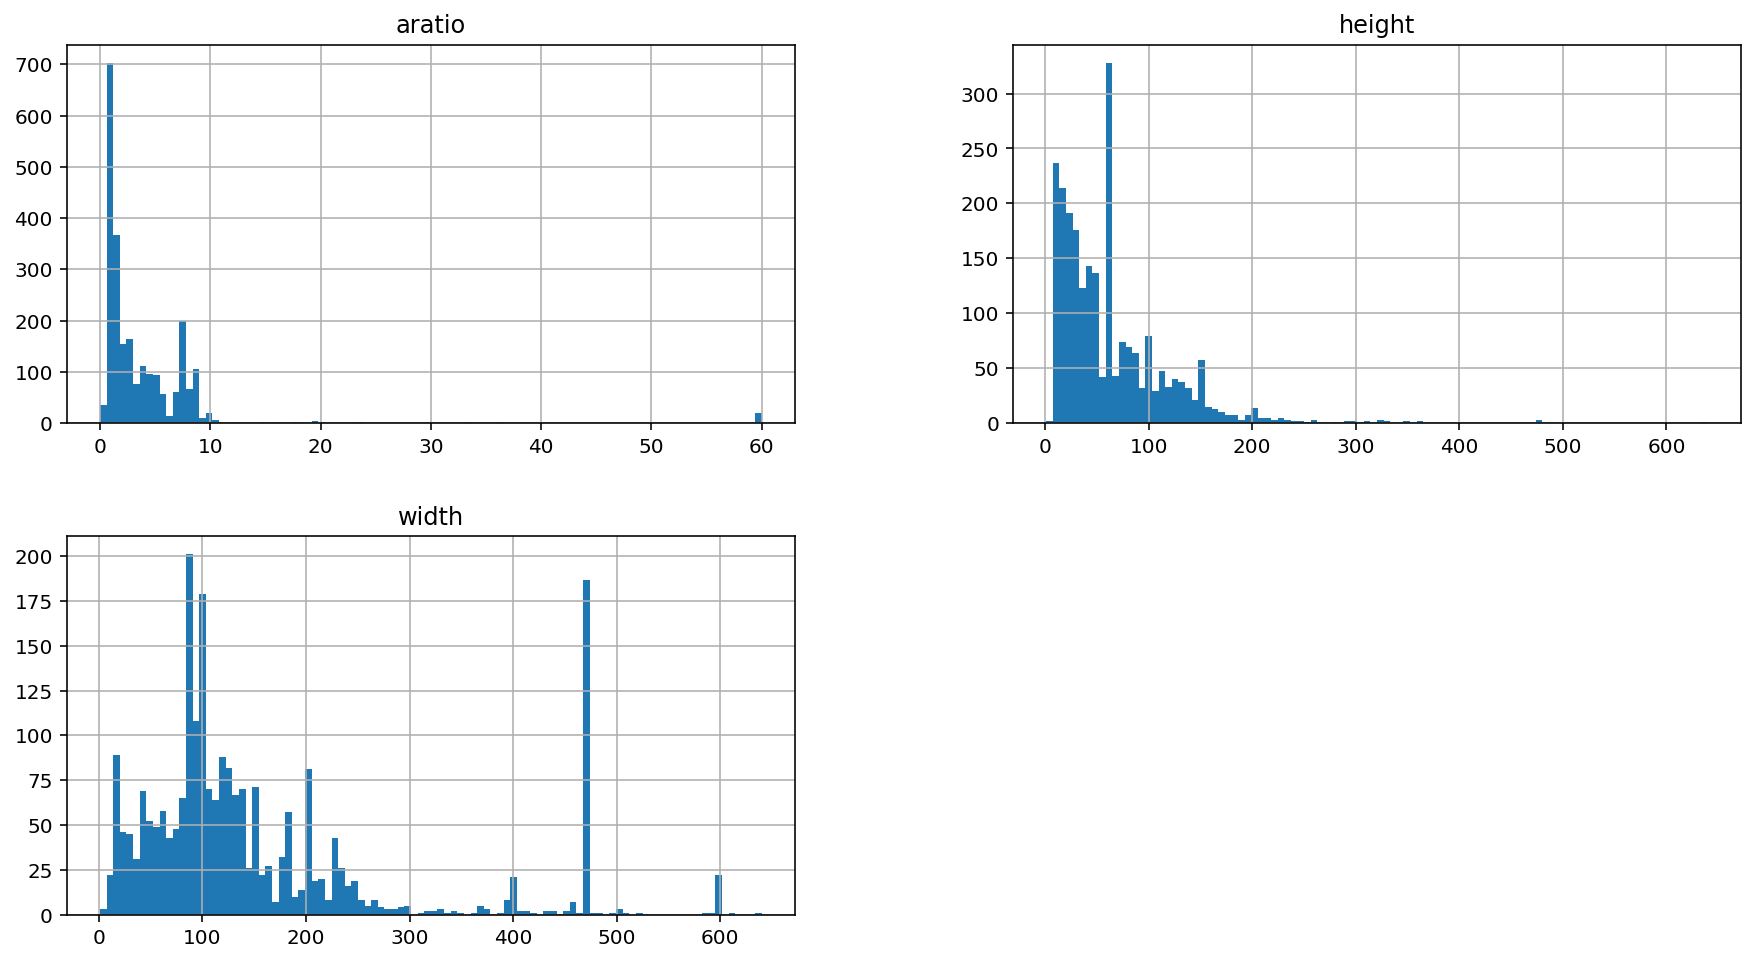

In [9]:
data[continuous_features].hist(bins=100, figsize=(15,8))

# 分开实现
# n_bins = 10
# fig, axes = plt.subplots(nrows=2, ncols=2)
# ax0, ax1, ax2, ax3 = axes.flatten()

# colors = ['red', 'tan', 'lime']

# ax0.hist(data['height'], n_bins, density=True, histtype='bar')
# ax0.legend(prop={'size': 10})
# ax0.set_title('1')


# ax1.hist(data['width'], n_bins, density=True, histtype='bar')
# ax1.legend(prop={'size': 10})
# ax1.set_title('2')


# ax2.hist(data['aratio'], n_bins, density=True, histtype='bar')
# ax2.legend(prop={'size': 10})
# ax2.set_title('3')

plt.show()

### 目标值分布

In [10]:
# 目标值正负样本分布不是很均匀，训练模型时可设置超参数scale_pos_weight
data['label'].value_counts()

1    2820
0     459
Name: label, dtype: int64

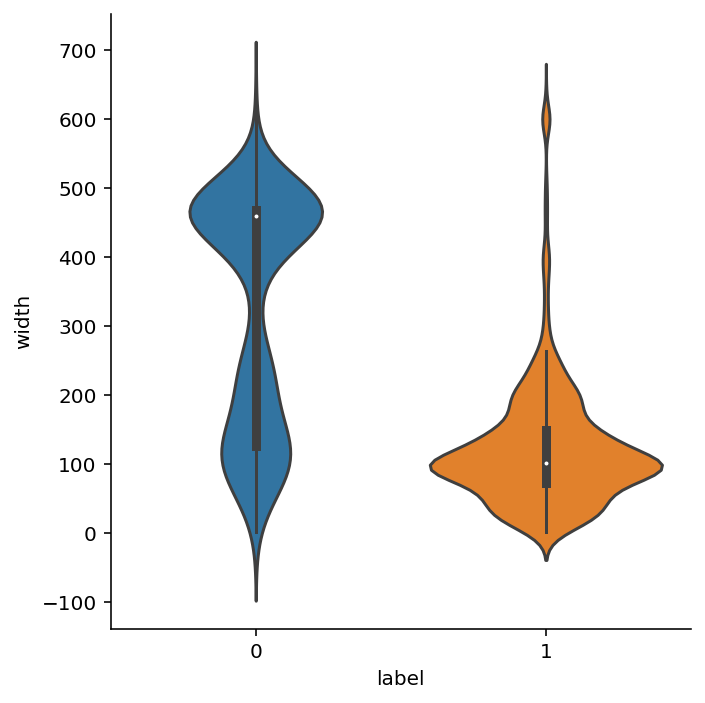

In [11]:
# 这几个连续值与目标值的分布
sns.catplot(x='label', y='width', kind="violin", data=data)

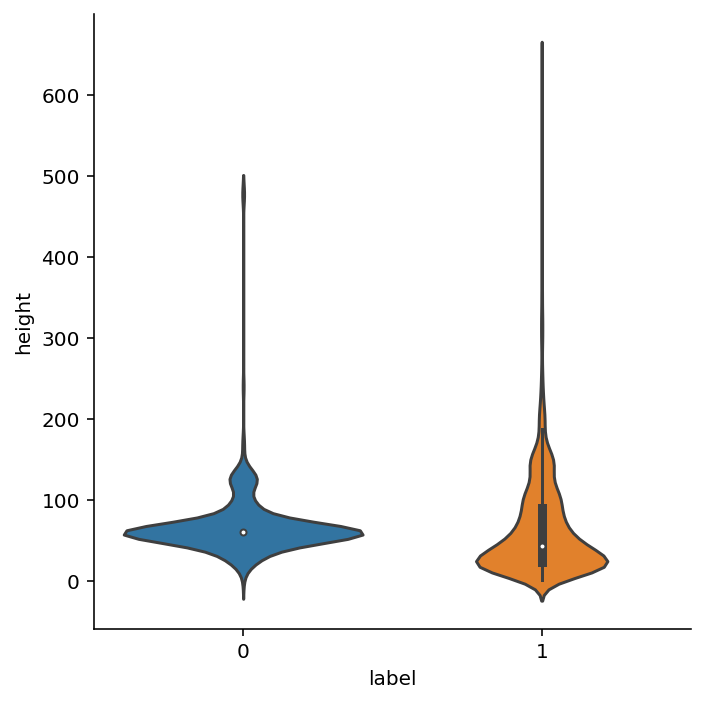

In [12]:
sns.catplot(x='label', y='height', kind="violin", data=data)

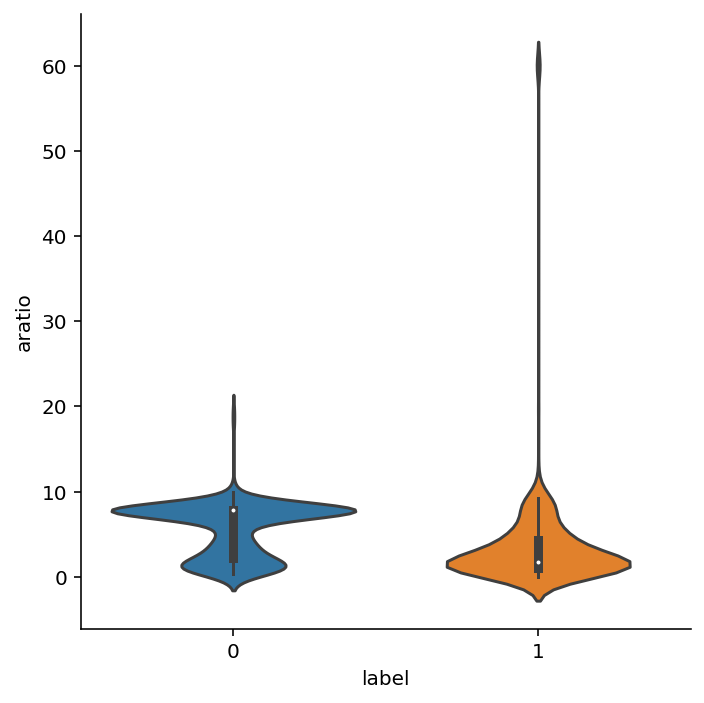

In [13]:
sns.catplot(x='label', y='aratio', kind="violin", data=data)

### 训练集与测试集分布比较

In [14]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=666)

train_df['label'] = 0
test_df['label'] = 1
all_df = pd.concat([train_df, test_df], ignore_index=True)
# sklearn里作为模型输入数据不能为空
all_df = all_df.fillna(0)

/Users/cleland/.pyenv/versions/3.7.1/envs/base/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cleland/.pyenv/versions/3.7.1/envs/base/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
from sklearn.metrics import roc_auc_score

y_tmp = all_df['label']
X_tmp = all_df.drop(['label'], 1)
# 划分训练与测试数据集
X_tmp_train, X_tmp_test, y_tmp_train, y_tmp_test = train_test_split(X_tmp, y_tmp, test_size=0.8, random_state=666)

In [16]:
from sklearn.linear_model import LogisticRegression

# 使用逻辑回归
clf = LogisticRegression()
clf.fit(X_tmp_train, y_tmp_train)
pre_df = clf.predict_proba(X_tmp_test)[:,1]
roc_auc_score(y_tmp_test, pre_df)

/Users/cleland/.pyenv/versions/3.7.1/envs/base/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.510313914549499

In [17]:
from sklearn.tree import DecisionTreeClassifier

# 使用决策树
clf = DecisionTreeClassifier()
clf.fit(X_tmp_train, y_tmp_train)
pre_df = clf.predict_proba(X_tmp_test)[:,1]
roc_auc_score(y_tmp_test, pre_df)

0.48936664766101046

**结论:** 使用逻辑回归和绝对树，计算出的auc均接近与0.5. 说明训练和测试集特征分布比较一致。

## 基准模型

In [18]:
y = data['label']
X = data.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=666)


### 基准模型训练

In [19]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

params = {
    'objective': 'binary:logistic', 
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'scale_pos_weight': len(data[data['label']==0])/len(data[data['label']==1]),
    'evel_metric': 'auc',
    'nthread': 8,
    'seed': 666    
}

num_round = 5
watch_list = [(dtrain, 'train'), (dtest, 'test')]

model = xgb.train(params, dtrain, num_round, watch_list)
test_predict = model.predict(dtest)

print('Test auc: ', roc_auc_score(y_test, test_predict))

[21:04:39] WARNING: /private/var/folders/r3/1hhvx75j0bd4qcy9ng4_d1540000gn/T/pip-install-edftga4q/xgboost/xgboost/src/learner.cc:328: 
Parameters: { evel_metric, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.06412	test-error:0.09223
[1]	train-error:0.05344	test-error:0.07012
[2]	train-error:0.04886	test-error:0.06707
[3]	train-error:0.04886	test-error:0.06822
[4]	train-error:0.03206	test-error:0.06212
Test auc:  0.9233783402135574


### 特征重要性排名

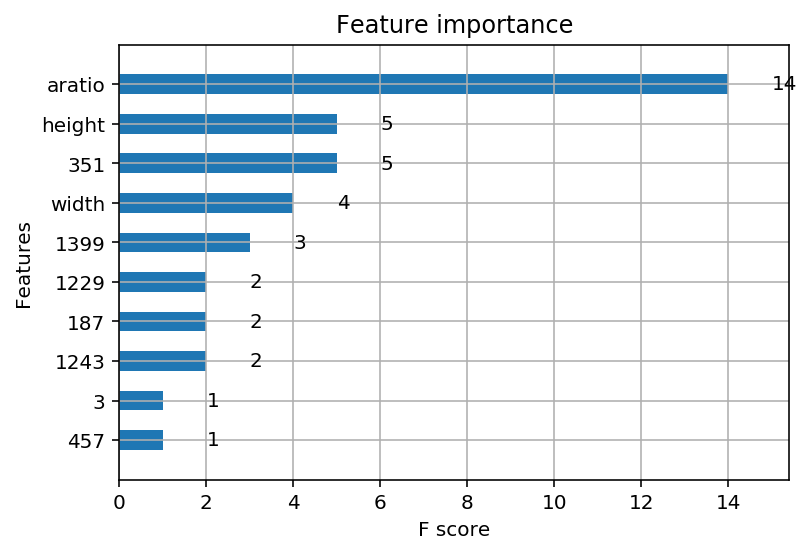

In [20]:
# 特征重要性排名
xgb.plot_importance(model, height=0.5)

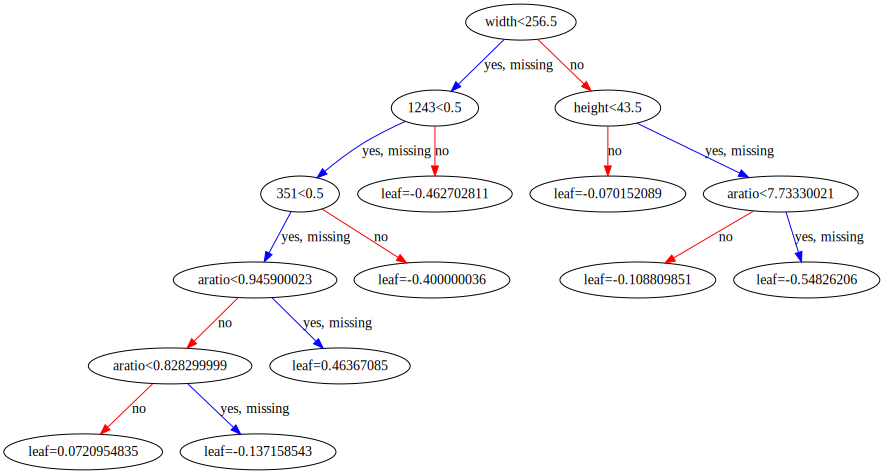

In [21]:
# 绘制决策过程
xgb.to_graphviz(model)


## 模型调优

### 超参数调优

### 模型融合